In [3]:
import pandas as pd
import numpy as np
from concat_stations import concat_files
import data_prep
from rf_optimize import evaluate
from scipy import stats

import json
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import matplotlib.pyplot as plt

In [2]:
# Load data and concatenate stations
full_data = concat_files()

# Replcae NaNs with medians
full_data = data_prep.nan_to_median(full_data)

# Get a dataframe with optimum features
full_data, df_features = data_prep.get_feature_df(full_data)

# Remove the outliers
full_data.apply(pd.to_numeric, errors='coerce')
new_full_data = data_prep.remove_outliers(full_data)

# Make target and feature arrays
y = np.array(new_full_data['bikes']) # array for target variable
X = new_full_data[df_features[0:-1]] # Features (discluding bikes)
X = np.array(X) # Turn into numpy array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state= 42)

In [7]:
# Begin with otpimum paramters computed for the random forest. 

# params = {'n_estimators' : 400, 'min_samples_split' : 2, 'min_samples_leaf' : 1, 
# 'max_features' : 'sqrt', 'max_depth' : None, 'bootstrap' : False}

# Using parameters from: https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [9]:
# Fit the model 

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mae = metrics.mean_absolute_error(y_test, reg.predict(X_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))

The mean absolute error (MAE) on test set: 2.3572


In [10]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

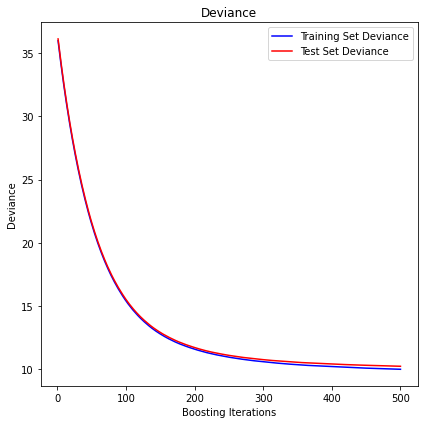

In [11]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()